In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1.

### 4.

In [2]:
def plot_feasible(obj, constrs, min_global, min_constrs):
  s = np.linspace(-2, 5, 1000)
  X, Y = np.meshgrid(s, s)

  plt.contour(X, Y, obj(X, Y), colors='k')
  plt.contour(X, Y, constrs(X, Y))
  plt.scatter(min_global[0], min_global[1], c='r', marker='*')
  plt.scatter(min_constrs[0], min_constrs[1], c='b', marker='*', zorder=2)

  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.gca().set_aspect('equal', adjustable='box')
  plt.show()

In [3]:
def objective(x, y):
  return (x - 1)**2 + (y - 2.5)**2

def constraints(x, y):
  return (x - 2*y + 2 >= 0) & (-x - 2*y + 6 >= 0) & (-x + 2*y + 2 >= 0) & (x >= 0) & (y >= 0)

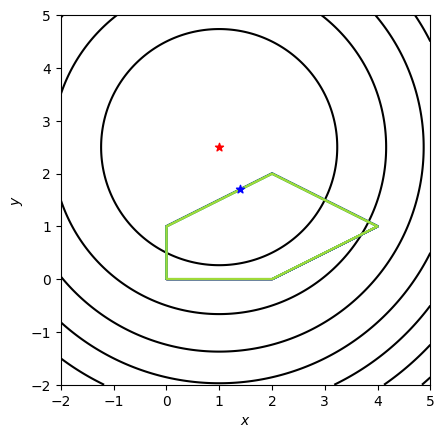

In [4]:
plot_feasible(objective, constraints, [1, 5 / 2], [14 / 10, 17 / 10])